<h1 style=\"text-align: center; font-size: 50px;\">🚫 Spam Detection with NLP (Natural Language Processing) </h1>
This notebook shows how to detect spam texts using Natural Language Processing (NPL)

## Notebook Overview
- Imports
- Configurations
- Loading Data
- Exploratory Data Analysis
- Text Pre-processing
- Vectorization
- Training a model
- Model Evaluation
- Train Test Split
- Creating a Data Pipeline
- Logging Model to MLflow
- Fetching the Latest Model Version from MLflow
- Loading the Model and Running Inference

## Imports

In [1]:
%pip install -r ../requirements.txt --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
# ------------------------ System Utilities ------------------------
import warnings
import logging
from pathlib import Path
import datetime
import os

# ------------------------ Data Manipulation ------------------------
import pandas as pd

# ------------------------ Data Visualization ------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------ Text Preprocessing ------------------------
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from types import SimpleNamespace
from sklearn.metrics import classification_report

# ------------------------ Machine Learning tools ------------------------
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import torch

# ------------------------ MLflow for Experiment Tracking and Model Management ------------------------
import mlflow
from mlflow import MlflowClient
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Configurations

In [3]:
# Suppress Python warnings
warnings.filterwarnings("ignore")

In [4]:
# Create logger
logger = logging.getLogger("nlp_logger")
logger.setLevel(logging.INFO)

formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s", 
                              datefmt="%Y-%m-%d %H:%M:%S")  

stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)
logger.propagate = False

In [5]:
# ------------------------- Paths -------------------------
DATA_PATH = '/home/jovyan/datafabric/tutorial/spam_utf8.csv'
NLTK_DIR_LOCAL  = '/home/jovyan/local/nltk_data'  
# ------------------------ MLflow Integration ------------------------
EXPERIMENT_NAME = "Spam_Detection_Experiment"
RUN_NAME = "Spam_Detection_Run"
MODEL_NAME = "Spam_Detection_Model"

In [6]:
logger.info('Notebook execution started.')

2025-06-03 15:21:12 - INFO - Notebook execution started.


## Verify Assets

In [7]:
def log_asset_status(asset_path: str, asset_name: str, success_message: str, failure_message: str) -> None:
    """
    Logs the status of a given asset based on its existence.

    Parameters:
        asset_path (str): File or directory path to check.
        asset_name (str): Name of the asset for logging context.
        success_message (str): Message to log if asset exists.
        failure_message (str): Message to log if asset does not exist.
    """
    if Path(asset_path).exists():
        logger.info(f"{asset_name} is properly configured. {success_message}")
    else:
        logger.info(f"{asset_name} is not properly configured. {failure_message}")

log_asset_status(
    asset_path=DATA_PATH,
    asset_name="Spam data",
    success_message="",
    failure_message="Please create and download the required assets in your project on AI Studio."
)

log_asset_status(
    asset_path=NLTK_DIR_LOCAL,
    asset_name="NLTK Path",
    success_message="",
    failure_message="Please check if NLTK was downloaded."
)

2025-06-03 15:21:12 - INFO - Spam data is properly configured. 
2025-06-03 15:21:12 - INFO - NLTK Path is properly configured. 


## Loading Data

In [8]:
messages = [line.rstrip() for line in open(DATA_PATH)]
logger.info(len(messages))

2025-06-03 15:21:12 - INFO - 5575


In [9]:
for message_no, message in enumerate(messages[:3]):
    print(message_no, message)
    print('\n')

0 v1,v2,,,


1 ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",,,


2 ham,Ok lar... Joking wif u oni...,,,




In [10]:
messages = pd.read_csv(DATA_PATH, sep=',',
                           names=["label", "message", "v3", "v4", "v5"])
messages.head()

label                                            message   v3   v4   v5
0    v1                                                 v2  NaN  NaN  NaN
1   ham  Go until jurong point, crazy.. Available only ...  NaN  NaN  NaN
2   ham                      Ok lar... Joking wif u oni...  NaN  NaN  NaN
3  spam  Free entry in 2 a wkly comp to win FA Cup fina...  NaN  NaN  NaN
4   ham  U dun say so early hor... U c already then say...  NaN  NaN  NaN

## Exploratory Data Analysis

In [11]:
messages.describe()

label                 message  \
count   5573                    5573   
unique     3                    5170   
top      ham  Sorry, I'll call later   
freq    4825                      30   

                                                       v3  \
count                                                  50   
unique                                                 43   
top      bt not his girlfrnd... G o o d n i g h t . . .@"   
freq                                                    3   

                           v4       v5  
count                      12        6  
unique                     10        5  
top      MK17 92H. 450Ppw 16"  GNT:-)"  
freq                        2        2

In [12]:
messages.groupby('label').describe()

message                                                                 \
        count unique                                                top freq   
label                                                                          
ham      4825   4516                             Sorry, I'll call later   30   
spam      747    653  Please call our customer service representativ...    4   
v1          1      1                                                 v2    1   

         v3                                                                 \
      count unique                                                top freq   
label                                                                        
ham      45     39   bt not his girlfrnd... G o o d n i g h t . . .@"    3   
spam      5      4                                        PO Box 5249    2   
v1        0      0                                                NaN  NaN   

         v4                                       v5                       
      count unique                    top freq count unique      top freq  
label                                                                      
ham      10      9                     GE    2     6      5  GNT:-)"    2  
spam      2      1   MK17 92H. 450Ppw 16"    2     0      0      NaN  NaN  
v1        0      0                    NaN  NaN     0      0      NaN  NaN

In [13]:
messages['length'] = messages['message'].apply(len)
messages.head()

label                                            message   v3   v4   v5  \
0    v1                                                 v2  NaN  NaN  NaN   
1   ham  Go until jurong point, crazy.. Available only ...  NaN  NaN  NaN   
2   ham                      Ok lar... Joking wif u oni...  NaN  NaN  NaN   
3  spam  Free entry in 2 a wkly comp to win FA Cup fina...  NaN  NaN  NaN   
4   ham  U dun say so early hor... U c already then say...  NaN  NaN  NaN   

   length  
0       2  
1     111  
2      29  
3     155  
4      49

In [14]:
messages

label                                            message   v3   v4   v5  \
0       v1                                                 v2  NaN  NaN  NaN   
1      ham  Go until jurong point, crazy.. Available only ...  NaN  NaN  NaN   
2      ham                      Ok lar... Joking wif u oni...  NaN  NaN  NaN   
3     spam  Free entry in 2 a wkly comp to win FA Cup fina...  NaN  NaN  NaN   
4      ham  U dun say so early hor... U c already then say...  NaN  NaN  NaN   
...    ...                                                ...  ...  ...  ...   
5568  spam  This is the 2nd time we have tried 2 contact u...  NaN  NaN  NaN   
5569   ham              Will Ì_ b going to esplanade fr home?  NaN  NaN  NaN   
5570   ham  Pity, * was in mood for that. So...any other s...  NaN  NaN  NaN   
5571   ham  The guy did some bitching but I acted like i'd...  NaN  NaN  NaN   
5572   ham                         Rofl. Its true to its name  NaN  NaN  NaN   

      length  
0          2  
1        111  
2         29  
3        155  
4         49  
...      ...  
5568     161  
5569      37  
5570      57  
5571     125  
5572      26  

[5573 rows x 6 columns]

### Data Visualization

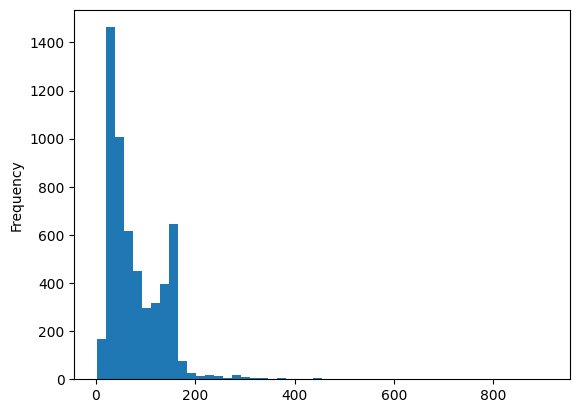

In [15]:
messages['length'].plot(bins=50, kind='hist');

In [16]:
messages.length.describe()

count    5573.000000
mean       80.105150
std        59.695104
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: length, dtype: float64

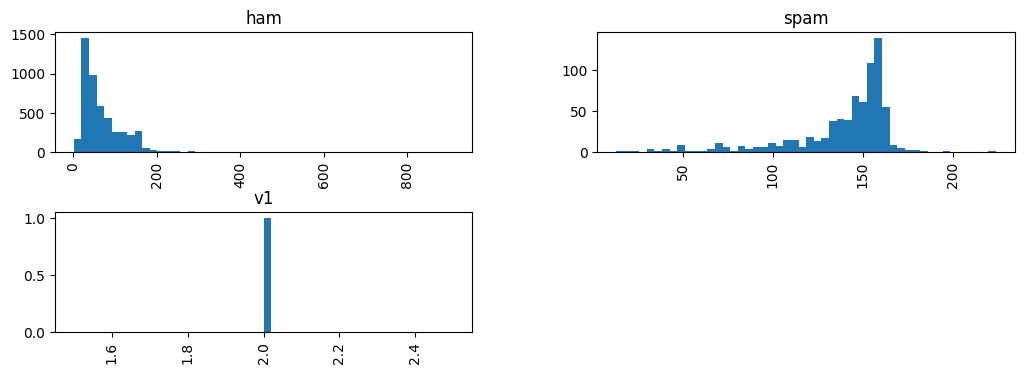

In [17]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4));

## Text Pre-processing

In [18]:
mess = 'Sample message! Notice: it has punctuation.'

# Check characters to see if they are in punctuation
nopunc = [char for char in mess if char not in string.punctuation]

# Join the characters again to form the string.
nopunc = ''.join(nopunc)

In [19]:
stopwords.words('english')[0:10] # Show some stop words

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']

In [20]:
nopunc.split()

['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

In [21]:
# Now just remove any stopwords
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [22]:
clean_mess

['Sample', 'message', 'Notice', 'punctuation']

In [23]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [24]:
messages.head()

label                                            message   v3   v4   v5  \
0    v1                                                 v2  NaN  NaN  NaN   
1   ham  Go until jurong point, crazy.. Available only ...  NaN  NaN  NaN   
2   ham                      Ok lar... Joking wif u oni...  NaN  NaN  NaN   
3  spam  Free entry in 2 a wkly comp to win FA Cup fina...  NaN  NaN  NaN   
4   ham  U dun say so early hor... U c already then say...  NaN  NaN  NaN   

   length  
0       2  
1     111  
2      29  
3     155  
4      49

In [25]:
# Check to make sure its working
messages['message'].head(5).apply(text_process)

0                                                 [v2]
1    [Go, jurong, point, crazy, Available, bugis, n...
2                       [Ok, lar, Joking, wif, u, oni]
3    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
4        [U, dun, say, early, hor, U, c, already, say]
Name: message, dtype: object

In [26]:
# Show original dataframe
messages.head()

label                                            message   v3   v4   v5  \
0    v1                                                 v2  NaN  NaN  NaN   
1   ham  Go until jurong point, crazy.. Available only ...  NaN  NaN  NaN   
2   ham                      Ok lar... Joking wif u oni...  NaN  NaN  NaN   
3  spam  Free entry in 2 a wkly comp to win FA Cup fina...  NaN  NaN  NaN   
4   ham  U dun say so early hor... U c already then say...  NaN  NaN  NaN   

   length  
0       2  
1     111  
2      29  
3     155  
4      49

## Vectorization

In [27]:
# Might take awhile...
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

# Print total number of vocab words
logger.info(len(bow_transformer.vocabulary_))

2025-06-03 15:21:15 - INFO - 11305


In [28]:
message4 = messages['message'][3]
logger.info(message4)

2025-06-03 15:21:15 - INFO - Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


In [29]:
bow4 = bow_transformer.transform([message4])
logger.info(bow4)
logger.info(bow4.shape)

2025-06-03 15:21:15 - INFO -   (0, 73)	1
  (0, 422)	1
  (0, 429)	1
  (0, 442)	1
  (0, 860)	1
  (0, 1529)	1
  (0, 1808)	2
  (0, 1909)	1
  (0, 2754)	1
  (0, 3882)	1
  (0, 4652)	1
  (0, 5535)	1
  (0, 6244)	2
  (0, 6470)	1
  (0, 9050)	1
  (0, 9091)	1
  (0, 9143)	1
  (0, 10398)	1
  (0, 10570)	1
  (0, 10965)	1
  (0, 11004)	1
2025-06-03 15:21:15 - INFO - (1, 11305)


In [30]:
logger.info(bow_transformer.get_feature_names_out()[4073])
logger.info(bow_transformer.get_feature_names_out()[9570])

2025-06-03 15:21:15 - INFO - VALUED
2025-06-03 15:21:15 - INFO - shades


In [31]:
messages_bow = bow_transformer.transform(messages['message'])

In [32]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5573, 11305)
Amount of Non-Zero occurences:  50194


In [33]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
logger.info('sparsity: {}'.format(round(sparsity)))

2025-06-03 15:21:17 - INFO - sparsity: 0


In [34]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
logger.info(tfidf4)

2025-06-03 15:21:17 - INFO -   (0, 73)	0.22530148292327545
  (0, 422)	0.09655957814015752
  (0, 429)	0.21770053859292315
  (0, 442)	0.21770053859292315
  (0, 860)	0.21180478813214076
  (0, 1529)	0.21770053859292315
  (0, 1808)	0.4506029658465509
  (0, 1909)	0.15260224741239434
  (0, 2754)	0.1765322780910631
  (0, 3882)	0.15434494495713846
  (0, 4652)	0.16446411145070872
  (0, 5535)	0.1886737355820859
  (0, 6244)	0.3477758790643801
  (0, 6470)	0.18460086887243252
  (0, 9050)	0.22530148292327545
  (0, 9091)	0.22530148292327545
  (0, 9143)	0.16115713415560878
  (0, 10398)	0.21180478813214076
  (0, 10570)	0.1399045307498735
  (0, 10965)	0.15964693257124865
  (0, 11004)	0.19097269229832803


In [35]:
logger.info(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
logger.info(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

2025-06-03 15:21:17 - INFO - 3.2890424768954527
2025-06-03 15:21:17 - INFO - 8.527255919373783


In [36]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
logger.info(messages_tfidf.shape)

2025-06-03 15:21:17 - INFO - (5573, 11305)


## Training a model

In [37]:
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

In [38]:
print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected:', messages.label[3])

predicted: spam
expected: spam


## Model Evaluation

In [39]:
all_predictions = spam_detect_model.predict(messages_tfidf)
logger.info(all_predictions)

2025-06-03 15:21:17 - INFO - ['ham' 'ham' 'ham' ... 'ham' 'ham' 'ham']


In [40]:
logger.info(classification_report(messages['label'], all_predictions))

2025-06-03 15:21:17 - INFO -               precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747
          v1       0.00      0.00      0.00         1

    accuracy                           0.98      5573
   macro avg       0.66      0.62      0.64      5573
weighted avg       0.98      0.98      0.98      5573



## Train Test Split

In [41]:
msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4458 1115 5573


## Creating a Data Pipeline

In [42]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [43]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7f2ac09cb6a0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [44]:
predictions = pipeline.predict(msg_test)

In [45]:
report = classification_report(predictions,label_test)
logger.info(report)

2025-06-03 15:21:19 - INFO -               precision    recall  f1-score   support

         ham       1.00      0.95      0.98      1013
        spam       0.68      1.00      0.81       102

    accuracy                           0.96      1115
   macro avg       0.84      0.98      0.89      1115
weighted avg       0.97      0.96      0.96      1115



## Logging Model to MLflow

In [46]:
def ensure_local_stopwords(base_dir: str):
    sw_file = Path(base_dir) / 'corpora' / 'stopwords' / 'english'
    if not sw_file.exists():
        sw_file.parent.mkdir(parents=True, exist_ok=True)
        logger.info("⬇️ Downloanding stopwords on %s …", base_dir)
        nltk.download('stopwords', download_dir=base_dir, quiet=True, raise_on_error=True)
    nltk.data.path = [base_dir]            

class SpamDetectionModel(mlflow.pyfunc.PythonModel):
    def preprocess(self, text: str):
        """
        Preprocesses the message, performing:
        1. Removal of all punctuation
        2. Removal of all stopwords
        3. Return of a list of the cleaned text
        """
        try:
            
            nopunc = ''.join(c for c in text if c not in string.punctuation)
            return [w for w in nopunc.split() if w.lower() not in self.stop_words]
            
        except Exception as e:
            logger.error(f"Error preprocessing: {str(e)}")
            raise

    def load_context(self, context):
        """Load model artifacts and pipeline."""
        try:
        
            nltk_dir = os.path.abspath(context.artifacts['nltk_data'])
            nltk.data.path = [nltk_dir]
            os.environ['NLTK_DATA'] = nltk_dir
    
            self.stop_words = set(stopwords.words('english'))
    
            df = pd.read_csv(context.artifacts['data_path'], sep=',',
                             names=['label', 'message', '_1', '_2', '_3'])
            X_tr, X_te, y_tr, y_te = train_test_split(
                df['message'], df['label'], test_size=0.2, random_state=42
            )
    
            self.pipeline = Pipeline([
                ('bow',   CountVectorizer(analyzer=self.preprocess)),
                ('tfidf', TfidfTransformer()),
                ('clf',   MultinomialNB()),
            ])
            self.pipeline.fit(X_tr, y_tr)
            self._X_test, self._y_test = X_te, y_te

        except Exception as e:
            logger.error(f"Error loading context: {str(e)}")

    def predict(self, context, model_input):
        """
        Computes the prediction of whether it is ham or spam.
        """
        try:
            
            return self.pipeline.predict(model_input)
            
        except Exception as e:
            logger.error(f"Error performing prediction: {str(e)}")

mlflow.set_experiment(EXPERIMENT_NAME)
ensure_local_stopwords(NLTK_DIR_LOCAL)

with mlflow.start_run() as run:

    mlflow.log_artifacts(NLTK_DIR_LOCAL, artifact_path='nltk_data')
    nltk_artifact_uri = mlflow.get_artifact_uri('nltk_data')

    ctx = SimpleNamespace(artifacts={
        'data_path': DATA_PATH,
        'nltk_data': nltk_artifact_uri
    })

    model = SpamDetectionModel()
    model.load_context(ctx)

    preds   = model.pipeline.predict(model._X_test)
    report  = classification_report(model._y_test, preds, output_dict=True)
    mlflow.log_metric('accuracy', report['accuracy'])

    signature = ModelSignature(
        inputs  = Schema([ColSpec('string', 'text')]),
        outputs = Schema([ColSpec('string')])
    )

    mlflow.pyfunc.log_model(
        artifact_path=MODEL_NAME,
        python_model=model,
        artifacts={
            'data_path': DATA_PATH,
            'nltk_data': nltk_artifact_uri
        },
        signature=signature,
        pip_requirements=[
            'scikit-learn==1.5.0',
            'nltk==3.9.1',
            'pandas',
            'mlflow',
            'cloudpickle==3.1.0'
        ]
    )

    model_uri = f"runs:/{run.info.run_id}/{MODEL_NAME}"
    mlflow.register_model(model_uri=model_uri, name=MODEL_NAME)

logger.info(f'Registered the model: {MODEL_NAME}')
logger.info(f'✅Stopwords packed in the artifact": {nltk_artifact_uri}')
 

/opt/conda/lib/python3.12/site-packages/mlflow/pyfunc/utils/data_validation.py:168: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


2025/06/03 15:21:21 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - cloudpickle (current: 3.1.1, required: cloudpickle==3.1.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
Registered model 'Spam_Detection_Model' already exists. Creating a new version of this model...
Created version '4' of model 'Spam_Detection_Model'.
2025-06-03 15:21:22 - INFO - Registered the model: Spam_Detection_Model
2025-06-03 15:21:22 - INFO - ✅Stopwords packed in the artifact": /phoenix/mlflow/475998940372908965/d4c3e7768f7e422787e333289e5b9745/artifacts/nltk_data


## Fetching the Latest Model Version from MLflow

In [47]:
# Initialize the MLflow client
client = MlflowClient()

# Retrieve the latest version of the "spam_detect_model" model 
model_metadata = client.get_latest_versions(MODEL_NAME, stages=["None"])
latest_model_version = model_metadata[0].version  # Extract the latest model version

# Fetch model information, including its signature
model_info = mlflow.models.get_model_info(f"models:/{MODEL_NAME}/{latest_model_version}")

# Print the latest model version and its signature
logger.info(f"Latest Model Version: {latest_model_version}")
logger.info(f"Model Signature: {model_info.signature}")

2025-06-03 15:21:22 - INFO - Latest Model Version: 4
2025-06-03 15:21:22 - INFO - Model Signature: inputs: 
  ['text': string (required)]
outputs: 
  [string (required)]
params: 
  None



## Loading the Model and Running Inference

In [48]:
model = mlflow.pyfunc.load_model(model_uri=f"models:/{MODEL_NAME}/{latest_model_version}")

# Define a sample text for testing
text = pd.DataFrame({'text': ["You have won a free ticket!"]})

# Use the model to predict 
result = model.predict(text)
logger.info(result)

2025/06/03 15:21:22 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - cloudpickle (current: 3.1.1, required: cloudpickle==3.1.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025-06-03 15:21:22 - INFO - ['ham']


In [49]:
logger.info('Notebook execution completed.')

2025-06-03 15:21:22 - INFO - Notebook execution completed.


Built with ❤️ using [**Z by HP AI Studio**](https://zdocs.datascience.hp.com/docs/aistudio/overview).